In [25]:
import tensorflow as tf
import os
import numpy as np
import cv2
# %matplotlib inline

# import matplotlib.pyplot as plt

In [26]:
SCALE_MIN = 0.7
SCALE_MAX = 1.3
SCALE_ABS = 1.171
SIGMA = 7.0

# tf.app.flags.DEFINE_float('scale_min', 0.7,
#                           """Maximum downscale perturbation.""")
# tf.app.flags.DEFINE_float('scale_max', 1.3,
#                           """Maximum upscale perturbation.""")
# tf.app.flags.DEFINE_float('scale_abs', 1.171,
#                           """Absolute scale.""")
# tf.app.flags.DEFINE_float('sigma', 16.0,
#                           """Sigma for joint heatmap.""")

In [27]:
# joint configuration
RIGHT_ANKLE=0
RIGHT_KNEE=1
RIGHT_HIP=2
LEFT_HIP=3
LEFT_KNEE=4
LEFT_ANKLE=5
RIGHT_WRIST=6
RIGHT_ELBOW=7
RIGHT_SHOULDER=8
LEFT_SHOULDER=9
LEFT_ELBOW=10
LEFT_WRIST=11
NECK=12
HEAD_TOP=13

IMAGE_SIZE = 368
IMAGE_SIZE_HALF = IMAGE_SIZE/2
NUM_MPI_JOINTS = 16
NUM_COMMON_JOINTS = 14
NUM_HEATMAPS = NUM_COMMON_JOINTS+1
NORMALIZER = 1.0/(2*SIGMA*SIGMA)
TRANSLATION_PERTURB = 10
IMAGE_SIZE_WITH_PADDING = IMAGE_SIZE + 2*TRANSLATION_PERTURB

def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'image_raw': tf.FixedLenFeature([],tf.string),
            'height': tf.FixedLenFeature([],tf.int64),
            'width': tf.FixedLenFeature([],tf.int64),
            'num_people': tf.FixedLenFeature([],tf.int64),
            'scales': tf.VarLenFeature(tf.float32),
            'joints': tf.VarLenFeature(tf.float32),
            'centers': tf.VarLenFeature(tf.float32)
        })
    height = tf.cast(features['height'],tf.int32)
    width = tf.cast(features['width'],tf.int32)
    nop = tf.cast(features['num_people'],tf.int32)
    scales = tf.sparse_tensor_to_dense(features['scales'])
    joints = tf.sparse_tensor_to_dense(features['joints'])
    joints = tf.reshape(joints, [NUM_MPI_JOINTS*nop,3])
    centers = tf.sparse_tensor_to_dense(features['centers'])
    centers = tf.reshape(centers,[nop,2])
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    image = tf.reshape(image, tf.pack([height, width, 3]))

    return image,height,width,nop,scales,centers,joints

def _reorder_joints(joints):
    indices = [0,1,2,3,4,5,10,11,12,13,14,15,8,9]
    reordered_joints = tf.gather(joints,indices)
    return reordered_joints

def _random_resize(image,joints,center,scale):
    
    scale_abs = SCALE_ABS/scale
    scale_mul = tf.random_uniform([1], minval=SCALE_MIN, 
                                  maxval=SCALE_MAX)
    scale_rnd = scale_mul[0] * scale_abs
    resized_joints = tf.scalar_mul(scale_rnd,joints)
    resized_center = tf.scalar_mul(scale_rnd,center)
    new_width  = tf.cast(tf.cast(tf.shape(image)[1],tf.float32)*scale_rnd,tf.int32)
    new_height = tf.cast(tf.cast(tf.shape(image)[0],tf.float32)*scale_rnd,tf.int32)
    resized_image  = tf.image.resize_images(image, 
                                            [new_height, new_width])
    return resized_image,resized_joints,resized_center

def _add_invisible_joint_heatmap(heatmap, joint):
    return heatmap

def _add_visible_joint_heatmap(heatmap, joint):
    height = tf.shape(heatmap)[0]
    width  = tf.shape(heatmap)[1]
    ones = tf.ones_like(heatmap)
    joint_x = joint[0] * ones
    joint_y = joint[1] * ones
    
    y_range = tf.range(height)
    x_range = tf.range(width)
    X,Y = tf.meshgrid(x_range,y_range)
    X = tf.to_float(X)
    Y = tf.to_float(Y)
    D = (tf.square(joint_x-X)+tf.square(joint_y-Y))*NORMALIZER
    threshold_mask = tf.cast(D < 4.6052,tf.float32)
    D = tf.mul(tf.exp(-D),threshold_mask)
    D = D + heatmap
    D = tf.clip_by_value(D,0.0,1.0)
    return D

def _add_joint_heatmap(heatmap, joint, vis):
    # the joints is outside image if vis < 0
    return tf.cond(vis >= 0.0,
                   lambda: _add_visible_joint_heatmap(heatmap, joint),
                   lambda: _add_invisible_joint_heatmap(heatmap, joint))
    
def _background_heatmap(joint_heatmaps):
    heatmap_sum = tf.reduce_sum(joint_heatmaps,reduction_indices=2)
    ones = tf.ones_like(heatmap_sum)
    output = ones-heatmap_sum
    output = tf.clip_by_value(output,0.0,1.0)
    return output

def _add_background_heatmap(heatmap):
    background_heatmap = _background_heatmap(heatmap)
    background_heatmap = tf.expand_dims(background_heatmap,2)
    heatmap = tf.concat(2,[heatmap,background_heatmap])
    return heatmap

def _generate_self_heatmaps(height,width,joints,joints_vis):
    reordered_joints = _reorder_joints(joints[0,:,:])
    reordered_joints_vis = _reorder_joints(joints_vis[0,:])
    heatmap_overall = tf.zeros([height,width,1])
    for i in xrange(NUM_COMMON_JOINTS):
        heatmapi = tf.zeros(shape=[height,width])
        heatmapi = _add_joint_heatmap(heatmapi, 
                                      reordered_joints[i,:], 
                                      reordered_joints_vis[i])
        heatmapi = tf.expand_dims(heatmapi,2)
        heatmap_overall = tf.concat(2,[heatmap_overall,heatmapi])
    heatmap_overall = tf.slice(heatmap_overall,[0,0,1],[height,width,NUM_COMMON_JOINTS])
    return heatmap_overall

def _update_heatmaps(heatmaps,index,height,width,joints,joints_vis):
    reordered_joints = _reorder_joints(joints[index,:,:])
    reordered_joints_vis = _reorder_joints(joints_vis[index,:])
    heatmap_overall = tf.zeros([height,width,1])
    for i in xrange(NUM_COMMON_JOINTS):
        heatmapi = _add_joint_heatmap(heatmaps[:,:,i], 
                                      reordered_joints[i,:], 
                                      reordered_joints_vis[i])
        heatmapi = tf.expand_dims(heatmapi,2)
        heatmap_overall = tf.concat(2,[heatmap_overall,heatmapi])
    heatmap_overall = tf.slice(heatmap_overall,[0,0,1],[height,width,NUM_COMMON_JOINTS])    
    return heatmap_overall

def generate_heatmaps(height,width,joints,joints_vis,nop):
    self_heatmaps = _generate_self_heatmaps(height,width,joints,joints_vis)
    all_heatmaps = tf.identity(self_heatmaps)
    
    i0 = tf.constant(1)
    cond = lambda i, heatmap: i < nop
    body = lambda i, heatmap: [i+1, _update_heatmaps(heatmap,i,height,width,joints,joints_vis)]
    all_heatmaps = tf.while_loop(cond, body, 
                                 loop_vars=[i0, all_heatmaps])  
    all_heatmaps = all_heatmaps[1]
    self_heatmaps = _add_background_heatmap(self_heatmaps)
    all_heatmaps = _add_background_heatmap(all_heatmaps)
    all_heatmaps = tf.concat(2,[self_heatmaps,all_heatmaps])
    return all_heatmaps

def _crop_pad(image, center, joints, size):
    height = tf.shape(image)[0]
    width  = tf.shape(image)[1]
    x_start = tf.cast(center[0]-(size-1)*0.5,tf.int32)
    x_end = x_start + size
    pad_width = tf.cast(x_start < 0,tf.int32)*-x_start
    pad_image_width = tf.cond(x_end > width, 
                              lambda: x_end+pad_width,
                              lambda: width+pad_width)
    y_start = tf.cast(center[1]-(size-1)*0.5,tf.int32)
    y_end = y_start + size
    pad_height = tf.cast(y_start < 0,tf.int32)*-y_start
    pad_image_height = tf.cond(y_end > height, 
                               lambda: y_end+pad_height,
                               lambda: height+pad_height)
    pad_image = tf.image.pad_to_bounding_box(image,pad_height,pad_width,
                                             pad_image_height,
                                             pad_image_width)
    
    crop_x = tf.cast(x_start >= 0,tf.int32)*x_start
    crop_y = tf.cast(y_start >= 0,tf.int32)*y_start
    crop_image = tf.image.crop_to_bounding_box(pad_image,crop_y,crop_x,
                                               size,size)
    
    crop_joints = tf.add(joints,tf.cast([pad_width-crop_x,pad_height-crop_y],tf.float32))
    return crop_image,crop_joints
    
def distorted_inputs(filenames,batch_size,total_inputs):
    # read a batch of images and labels
    filename_queue = tf.train.string_input_producer(filenames)
    image,height,width,nop,scales,centers,joints = read_and_decode(filename_queue)
    # separate joint locations and their visibility
    joints_loc = tf.slice(joints,[0,0],[NUM_MPI_JOINTS*nop,2])
    # convert matlab coordinate system to 0-based
    joints_loc -= 1.0
    joints_vis = tf.slice(joints,[0,2],[NUM_MPI_JOINTS*nop,1])
    joints_vis = tf.squeeze(joints_vis)
    
    # apply image preprocessing
    resized_image,resized_joints,resized_center = _random_resize(image,joints_loc,centers[0,:],scales[0])
    crop_image,crop_joints = _crop_pad(resized_image, resized_center, resized_joints,IMAGE_SIZE_WITH_PADDING)
    # generate joint heatmaps
    reshaped_joints_loc = tf.reshape(crop_joints,[nop,NUM_MPI_JOINTS,2])
    reshaped_joints_vis = tf.reshape(joints_vis,[nop,NUM_MPI_JOINTS])
    heatmap_all = generate_heatmaps(IMAGE_SIZE_WITH_PADDING,
                                    IMAGE_SIZE_WITH_PADDING,
                                    reshaped_joints_loc,
                                    reshaped_joints_vis,
                                    nop)
    image_label = tf.concat(2,[crop_image,heatmap_all])
    # Randomly crop a [height, width] section of the image.
    distorted_image_label = tf.random_crop(image_label, [IMAGE_SIZE, IMAGE_SIZE, 3+NUM_HEATMAPS*2])
    # Randomly flip the image horizontally.
    distorted_image_label = tf.image.random_flip_left_right(distorted_image_label)
    distorted_image = tf.slice(distorted_image_label,[0,0,0],[IMAGE_SIZE,IMAGE_SIZE,3])
    distorted_image = distorted_image * (1. / 255) - 0.5
    distorted_label = tf.slice(distorted_image_label,[0,0,3],[IMAGE_SIZE,IMAGE_SIZE,NUM_HEATMAPS*2])
    
    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.05
    min_queue_examples = int(total_inputs *
                            min_fraction_of_examples_in_queue)
    print ('Filling queue with %d images before starting to train. '
            'This will take a few minutes.' % min_queue_examples)

    # Generate a batch of images and labels by building up a queue of examples.
    return _generate_image_and_label_batch(distorted_image, distorted_label,
                                            min_queue_examples, batch_size,
                                            shuffle=True)
    
def _generate_image_and_label_batch(image, label, min_queue_examples,
                                    batch_size, shuffle):
    """Construct a queued batch of images and labels.
    Args:
        image: 3-D Tensor of [height, width, 3] of type.float32.
        label: 3-D Tensor of [height, width, 30] of type.float32.
        min_queue_examples: int32, minimum number of samples to retain
          in the queue that provides of batches of examples.
        batch_size: Number of images per batch.
        shuffle: boolean indicating whether to use a shuffling queue.
    Returns:
        images: Images. 4D tensor of [batch_size, height, width, 3] size.
        labels: Labels. 3D tensor of [batch_size, height, width] size.
    """
    # Create a queue that shuffles the examples, and then
    # read 'batch_size' images + labels from the example queue.
    num_preprocess_threads = 2
    if shuffle:
        images, labels = tf.train.shuffle_batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size,
            min_after_dequeue=min_queue_examples)
    else:
        images, labels = tf.train.batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size)

    return images, labels
    

def plot_pose(joints):
    nop = joints.shape[0]
    for i in xrange(nop):
        plt.plot(joints[i,:,0],joints[i,:,1],'ro')
#     plt.plot(joints[RIGHT_ANKLE:RIGHT_WRIST,0], joints[RIGHT_ANKLE:RIGHT_WRIST,1], '-')
#     plt.plot(joints[RIGHT_WRIST:NECK,0], joints[RIGHT_WRIST:NECK,1], '-')
#     plt.plot(joints[[NECK,HEAD_TOP],0], joints[[NECK,HEAD_TOP],1], '-')
    
def blend_heatmap_with_image(heatmaps,image,alpha=0.5):
    image_float = image.astype(np.float32)
    image_float_half = image_float*(1.0-alpha)
    for i in xrange(NUM_COMMON_JOINTS):
        mapi = alpha*heatmaps[:,:,i]*image_float
        image_float_half += mapi
#     image_float[:,:,1] = image_float[:,:,1] * foreground
#     image_float[:,:,2] = image_float[:,:,2] * foreground
    output = image_float_half.astype(np.uint8)
    return output


In [28]:
# DIRECTORY = '/Users/xuehan.xiong/Google Drive/datasets/human_pose'
# TFRECORD_FILE = os.path.join(DIRECTORY, 'MPI_test.tfrecords')

# file_path = os.path.join(DIRECTORY,TFRECORD_FILE)
# images,heatmaps = distorted_inputs([file_path],32,1000)
# init = tf.initialize_all_variables()

# sess = tf.InteractiveSession()
# sess.run(init)
# # Start the queue runners.
# tf.train.start_queue_runners(sess=sess)


Filling queue with 50 images before starting to train. This will take a few minutes.


[<Thread(Thread-8, started daemon 123145572347904)>,
 <Thread(Thread-9, started daemon 123145576554496)>,
 <Thread(Thread-10, started daemon 123145580761088)>]

In [29]:
# images_val,heatmaps_val = sess.run([images,heatmaps])


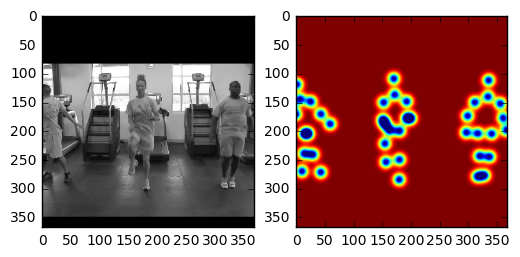

In [44]:
# print heatmaps_val[1,:,:,13]
# plt.imshow(heatmaps_val[1,:,:,13],cmap='jet')
# print np.amax(heatmaps_val[1,:,:,13])
# index = 11
# gray_image = cv2.cvtColor(images_val[index,:,:,:], cv2.COLOR_BGR2GRAY)
# #gray_blend = blend_heatmap_with_image(heatmaps_val[index,:,:,:],gray_image)
# plt.subplot(121)
# plt.imshow(gray_image,cmap='gray')
# plt.subplot(122)
# plt.imshow(heatmaps_val[index,:,:,29],cmap='jet')
# plt.show()